### Initialization

In [26]:
import glob
import json
import re
import numpy
import pandas
import time

In [2]:
from utils.text_extraction import *
from utils.document_processing import *
from utils.subject_extraction import *
from utils.similarity import *
from utils.context_extraction import *

In [3]:
import psycopg2
psycopg2_conn = psycopg2.connect(dbname='public_contracts', user='postgres', password='admin', host='localhost', port='5432')

### Subject context

In [4]:
from utils.context_extraction import *

In [5]:
from utils.similarity import *

In [6]:
from utils.evaluation import *

### EvaluationMachine

In [7]:
class SubjectContextSelectionEvaluationMachine():
    
    _contracts = None
    _df_contracts = None
    _subj_context_extractor = None
    _func_params = None
    
    def __init__(self, contracts, subj_context_extractor=SubjectContextExtractor, func_params={}):
        self._contracts = contracts
        self._subj_context_extractor = subj_context_extractor
        self._func_params = func_params
    
    def process(self):
        for contr in self._contracts:
            contr_text = contr['text']
            contr['subj_context'] = self._subj_context_extractor(**self._func_params).get_subject_context(contr_text)
        self._df_contracts = pandas.DataFrame(self._contracts).set_index('id')
        return self._df_contracts
    
    def evaluate(self):
        return self._df_contracts['subj_context'].isna().sum()

In [8]:
class ComplexSubjectContextSelectionEvaluationMachine(SubjectContextSelectionEvaluationMachine):
    
    _path_to_data = None
    _validator = None
    
    def __init__(self, path_to_data, validator=validate_subj_contexts, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._path_to_data = path_to_data
        self._validator = validator
    
    def process(self):
        super().process()
        self._df_contracts = self._validator(self._df_contracts, self._path_to_data)
        self._df_contracts['valid']=False
        df_tmp = self._df_contracts[self._df_contracts.valid_rat>0.5].copy()
        df_tmp['valid']=True
        self._df_contracts['valid']=df_tmp['valid']
        return self._df_contracts
        
    def evaluate(self):
        return self._df_contracts['valid_rat'].mean()*100

In [9]:
class ContextExtractionEvaluationMachine:
    
    def __init__(self, df_contracts, subj_context_extractor=AdvancedSubjectContextExtractor(), validator=validate_subjects):
        self._df_contracts = df_contracts
        self._subj_context_extractor = subj_context_extractor
        self._validator = validator
        
    def preprocess(self):
        self._df_contracts['subj_context'] = self._df_contracts['text'].apply(\
            lambda text: self._subj_context_extractor.process(text))
        return self._df_contracts
    
    def process(self):
        self._df_contracts = self._validator(self._df_contracts, 'subj_context')
        return self._df_contracts

    def evaluate(self):
        return self._df_contracts['valid_score'].mean()*100

### Documents 

In [10]:
from utils.document_processing import *

In [11]:
loader = DatabaseDocumentLoader(psycopg2_conn)
loader.load_documents()
documents = loader.prepare_documents()

Running query: select * from document where processed=True
Preparing total 1008 documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 100.0%


In [12]:
vzdirs = '../../test-data/*/*/*/*'
ignore_contracts = ['2096','sportovni-areal-zs-slatina-1-etapa_25534',
                    'revitalizace-lokality-spaliste-k-u-stare-mesto-u-uherskeho-hradiste-akceptacni-cislo-12136894-cz-1-02-4-2-00-12-16399-dodatecne-prace_9496',
                    '35226', 'kompostujeme-v-obci-sebranice-dodavka-stepkovace-a-komposteru', 'zvysovani-povedomi-verejnosti-o-biodiverzite-luk-a-pastvin',
                    'nakup-noveho-uzitkoveho-elektromobilu-typu-bev-vozidlo-s-bateriovym-pohonem']

ref_loader = ReferenceDocumentLoader(vzdirs)
# ref_loader.extract_text_from_documents(0,1024)
ref_loader.load_documents_from_extracts(ignore_contracts)
ref_documents = ref_loader.prepare_documents()

Loading total 339 extracts
Preparing total 339 documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 39.0%
Progress: 49.0%
Progress: 59.0%
Progress: 69.0%
Progress: 78.0%
Progress: 88.0%
Progress: 98.0%


In [15]:
ignore_mask = count_occurence_vector('qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNMáčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ0123456789')
ignore_mask[0]=0
matcher = DocumentMatcher(ref_documents, documents)
matcher.count_most_similar_documents(ignore_mask=ignore_mask)
matcher.aggregate_documents()
df_contract = matcher.filter_aggregated()

Counting most similar documents for total 339 reference documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 39.0%
Progress: 49.0%
Progress: 59.0%
Progress: 69.0%
Progress: 78.0%
Progress: 88.0%
Progress: 98.0%


### Measurements

In [16]:
contracts = []
for contr_name, docs in df_contract.groupby('contr_name'):
    contr_text = ''
    contr_ids = []
    for index, doc in docs.iterrows():
        doc_name = doc['doc_name']
        contr_text += '======================='+doc_name+'=======================\n'
        contr_text += doc['doc_text']
        contr_ids.append(doc['contr_id'])
    contr_id = get_most_frequent(contr_ids)
    contr = {'id': contr_id, 'contr_name': contr_name, 'text': contr_text}
    contracts.append(contr)
df_contracts = pandas.DataFrame(contracts)
df_contracts

,id,contr_name,text
0,71,e-zakazky/48a575ba-f8fe-47f2-bbb6-c6ddb26390ef...,=======================2017126-115451.pdf=====...
1,72,e-zakazky/73b0be6b-6b49-4ab4-a6a0-508b83a305e1...,=======================Formulář - Informace o ...
2,74,e-zakazky/c265fdf8-044f-44e5-b36e-df4ca53c6179...,=======================Dodatečné informace 01....
3,61,eagri/mze/contract_display_6220,=======================01_výzva k podání nabíd...
4,64,ezak/mpsv/P15V00000447,=======================AKRIS_příloha-01_Kvalif...
5,66,ezak/mpsv/P16V00000187,=======================Příloha č. 1 SOD_Projek...
6,67,ezak/mpsv/P16V00000240,=======================P1_Výkaz výměr (slepý)....
7,103,nipez/mo/P18V00009525,=======================VZOR_smlouvy.doc=======...
8,207,nipez/mo/P18V00012708,=======================Oznámení o výběru dodav...
9,397,nipez/mo/P18V00019354,=======================PSP s přílohami.zip====...


In [17]:
last_score = 0

In [18]:
DEF_KEYWORDS = {
    'Předmět smlouvy': 10,
    'Předmět díla': 10,
    'Předmět plnění': 10,
    'Předmět veřejné zakázky': 10,
    'Vymezení předmětu': 10,
    'Vymezení plnění': 10,
    'Popis předmětu': 10,
    'Název veřejné zakázky': 3,
    'Veřejná zakázka': 1,
    'Veřejné zakázce': 1,
    'Předmět': 1,
    'Popis': 1
}

extractor = AdvancedSubjectContextExtractor(keywords = DEF_KEYWORDS, subj_range = 2040)

In [158]:
scores3 = {}

In [196]:
%%time 

DEF_KEYWORDS = {
    'Předmět smlouvy': 10,
    'Předmět díla': 10,
    'Předmět plnění': 10,
    'Předmět veřejné zakázky': 10,
    'Vymezení předmětu': 10,
    'Vymezení plnění': 10,
    'Popis předmětu': 10,
    'Název veřejné zakázky': 3,
    'Veřejná zakázka': 1,
    'Veřejné zakázce': 1,
    'Předmět': 1,
    'Popis': 1
}

extractor = AdvancedSubjectContextExtractor(keywords = DEF_KEYWORDS, subj_range = 2040)

evaluator = ContextExtractionEvaluationMachine(df_contracts,
                                               subj_context_extractor=extractor,
                                               validator=validate_subjects)

start = time.time()
evaluator.preprocess()
evaluator.process()
end = time.time()
elapsed_time = end - start
score = evaluator.evaluate()
print('Score: ' + str(score))
print('Time: ' + str(elapsed_time))
print('Improve: ' + str(score - last_score))
last_score = score
df_last_contracts = df_contracts
df_contracts = evaluator._df_contracts
scores2['all'] = {'score': score, 'time': elapsed_time}

Score: 100.0
Time: 12.177772045135498
Improve: 8.30763146101684
Wall time: 12.2 s


In [197]:
scores2

{'base': {'score': 34.14155701683546, 'time': 11.021192073822021},
 'whole_line': {'score': 78.95137659850141, 'time': 12.052140712738037},
 'exact_match': {'score': 77.30037970417305, 'time': 12.249453783035278},
 'upper_case': {'score': 64.82034561265661, 'time': 12.213369131088257},
 'chapter_title': {'score': 77.72935098445448, 'time': 11.925735235214233},
 'chapter_numbering': {'score': 65.2177344881828, 'time': 11.328416347503662},
 'subj_sentence': {'score': 64.25969847777579, 'time': 11.915678024291992},
 'chapter_header': {'score': 39.30499588594925, 'time': 11.676677465438843},
 'chapter_numbering_roman': {'score': 72.1243114018274,
  'time': 11.640754699707031},
 'goods_sentence': {'score': 64.75970522638589, 'time': 11.212205171585083},
 'sentence_following': {'score': 62.715448442134345,
  'time': 12.184731245040894},
 'w/o_whole_line': {'score': 96.53472500749353, 'time': 11.606983184814453},
 'w/o_exact_match': {'score': 97.13005863778864, 'time': 11.974584817886353},
 '

### Playground

In [195]:
class AdvancedSubjectContextExtractor(SubjectContextExtractor):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_subject_context_starts(self, text):
        raw_context_starts = super().get_subject_context_starts(text)
        raw_context_ends = super().get_subject_context_ends(text, raw_context_starts)
        starts = []
        for start in raw_context_starts:
            end = super().get_subject_context_end(text, start)
            start_occurrences = self.get_all_occurrences(text[start:end])
            df = pandas.DataFrame(start_occurrences, columns=['keyword', 'rat', 'occ'])
            df = df.sort_values(['rat'], ascending=False)
            if len(df.index) > 0:
                start += df.iloc[0]['occ']
            if start not in starts:
                starts.append(start)
        return starts

    def get_subject_context_end(self, text, start_position):
        end_position = SubjectContextEndDetector(text, self._subj_range).detect(start_position)

        detectors = [
            SubjectContextEndNumberingDetector,
            SubjectContextEndRomanNumberingDetector,
            SubjectContextEndHeaderDetector,
            SubjectContextEndCapitalsDetector,
            SubjectContextEndNameDetector,
            SubjectContextEndQuotationDetector,
            SubjectContextEndWordsDetector
        ]

        for detectorCls in detectors:
            detector = detectorCls(text, self._subj_range)
            if detector.detect(start_position, end_position):
                return detector._end_position

        return end_position


In [153]:
class SubjectContextExtractor:
    
    def __init__(self, keywords=DEF_KEYWORDS, subj_range=2040):
        self._keywords = keywords
        self._subj_range = subj_range

    def get_all_occurrences(self, text):
        occurrences = []
        for keyword in self._keywords:
            occ = find_all_occurrences_in_string(keyword, text)
            for o in occ:
                rat = self._keywords[keyword]
                koef = 1
                matched = keyword.lower()
                current_line = get_current_line(text, o)
                # Whole line
                if current_line.lower() == keyword.lower():
                    koef += 2
                # Exact pattern match
                if text[o:min(o + len(keyword), len(text))] == keyword:
                    koef += 1.5
                    matched = keyword
                # Upper case pattern match
                if text[o:min(o + len(keyword), len(text))] == keyword.upper():
                    koef += 1.5
                    matched = keyword.upper()
                # Nearly linebreak after the pattern (chapter title)
                if '\n' in text[o:min(o + len(keyword) * 3, len(text))]:
                    koef += 2
                # Newline followed by a number preceding the pattern (chapter numbering)
                if re.search(r"\n[ ]*[0-9]", text[max(o - 20, 0):o]):
                    koef += 2
                # Nearly verb ' je ' after the pattern (subject sentence matching)
                if ' je ' in text[o:min(o + len(keyword) * 2, len(text))]:
                    koef += 2
                # Word 'článek' preceding the pattern (chapter header)
                if 'článek' in text[max(o - 20, 0):o].lower():
                    koef += 2
                # Chars 'I' preceding the pattern (chapter numbering)
                if text[max(o - 20, 0):o].count('I') > 1:
                    koef += 2
                if 'Zboží' in text[o: min(o + 150, len(text))]:
                    koef *= 0.5
                # Simple sentences following
                koef += chars_occurrence_ratio(text[min(o + 50, len(text)): min(o + 100, len(text))])
                rat *= koef
                occurrences.append({'keyword': matched, 'rat': rat, 'occ': o})
        return occurrences

    def get_subject_context_old(self, text):
        occurrences = self.get_all_occurrences(text)
        df = pandas.DataFrame(occurrences).T
        df = df.sort_values('rat')
        df = flatten_column(df, 'occ')
        if len(df.index) > 0:
            occ = df.iloc[0]
        else:
            return None
        start = occ['occ_flat'] + len(occ.name)
        end = min(start + self._subj_range, len(text))
        subj_context = text[start:end]
        return subj_context

    def get_subject_context_starts(self, text):
        bin_size = int(self._subj_range / 3)
        bins = int(len(text) / bin_size) + 1
        text = text.ljust(bins * bin_size)

        occurrences = self.get_all_occurrences(text)
        df = pandas.DataFrame(occurrences, columns=['keyword', 'rat', 'occ'])

        hist = numpy.histogram(df['occ'], bins, weights=df['rat'], range=(0, len(text)))

        score = numpy.convolve(hist[0], numpy.array([1, 1, 2, -2, -1, -1]))[2:-3]

        max_score = score.max()
        threshold = max_score * 2 / 3
        top_bins = numpy.argwhere(score > threshold).flatten()

        starts = [subj_bin * bin_size for subj_bin in top_bins]
        return starts

    def get_subject_context_end(self, text, start):
        return min(start + self._subj_range, len(text))

    def get_subject_context_ends(self, text, starts):
        return [self.get_subject_context_end(text, start) for start in starts]

    def get_subject_contexts(self, text):
        starts = self.get_subject_context_starts(text)
        ends = self.get_subject_context_ends(text, starts)
        subj_contexts = [text[start:end] for start, end in zip(starts, ends)]
        return subj_contexts

    def process(self, text):
        return self.get_subject_contexts(text)

    def show_occurrence_distribution(self, text):
        bin_size = int(self._subj_range / 3)
        bins = int(len(text) / bin_size) + 1
        text = text.ljust(bins * bin_size)

        occurrences = self.get_all_occurrences(text)
        df = pandas.DataFrame(occurrences, columns=['keyword', 'rat', 'occ'])

        hist = numpy.histogram(df['occ'], bins, weights=df['rat'], range=(0, len(text)))
        score = numpy.convolve(hist[0], numpy.array([1, 1, 2, -2, -1, -1]))[2:-3]

        sorted_bins = numpy.argsort(score)[::-1]
        top_bins = sorted_bins[:min(5, len(sorted_bins))]
        starts = [subj_bin * bin_size for subj_bin in top_bins]

        ticks = [str(s) + ' (' + str(b) + ')' for b, s in zip(top_bins, starts)]
        ax = pandas.DataFrame(hist[0]).plot.bar(figsize=(15, 5), xticks=top_bins)
        ax.set_xticklabels(ticks, rotation=45)
        ax = pandas.DataFrame(score).plot.bar(figsize=(15, 7), xticks=top_bins)
        ax.set_xticklabels(ticks, rotation=45)


class SubjectContextEndDetector:

    def __init__(self, text, subj_range=2000, multip=3):
        self._text = text
        self._subj_range = subj_range
        self._multip = multip
        self._end_position = None

    def detect(self, start_position, end_position=None):
        self._end_position = min(start_position + self._subj_range * self._multip, len(self._text))
        return self._end_position


class SubjectContextEndNumberingDetector(SubjectContextEndDetector):

    def detect(self, start_position, end_position):
        # klasicke cislovani \n<num>. word
        subj_prefix = self._text[max(start_position - 50, 0):start_position]
        numeral_pattern = '\n[ \t]*[\d]+[^/]'
        start_occurrences = find_all_occurrences_in_string(numeral_pattern, subj_prefix, lower=False)
        if len(start_occurrences) > 0:
            # otocim text abych hledal prechazejici cislo, najdu cislo nasledujici newline a vratim ho
            article_num = int(
                re.search('[\d]+', re.search('[^/][\d]+[ \t]*\n', subj_prefix[::-1]).group(0)).group(0)[::-1])
            end_occurrences = find_all_occurrences_in_string(numeral_pattern, self._text[start_position:end_position],
                                                             lower=False)
            if len(end_occurrences) > 0:
                for occ in end_occurrences:
                    occ = start_position + occ
                    m = re.search('[\d]+', self._text[occ:occ + 10])
                    if m is None:
                        continue
                    num = int(m.group(0))
                    if (num > article_num) and (num < article_num + 3):
                        current_line = get_current_line(self._text, occ + 1)
                        if len(current_line) < 50:
                            num_numbers_in_line = len(find_all_occurrences_in_string('\d', current_line))
                            if num_numbers_in_line <= 5:
                                self._end_position = occ
                                return self._end_position
        return None


class SubjectContextEndRomanNumberingDetector(SubjectContextEndDetector):

    def detect(self, start_position, end_position):
        # rimske cislovani
        subj_prefix = self._text[max(start_position - 50, 0):start_position]
        roman_numeral_pattern = '\s(?=[XVI])(X{0,3})(I[XV]|V?I{0,3})[\s\W]+'
        start_occurrences = find_all_occurrences_in_string(roman_numeral_pattern, subj_prefix, lower=False)
        if len(start_occurrences) > 0:
            end_occurrences = find_all_occurrences_in_string(roman_numeral_pattern,
                                                             self._text[start_position:end_position], lower=False)
            if len(end_occurrences) > 0:
                for occ in end_occurrences:
                    occ = start_position + occ
                    if len(get_current_line(self._text, occ + 1)) < 50:
                        self._end_position = occ
                        return self._end_position
        return None


class SubjectContextEndHeaderDetector(SubjectContextEndDetector):

    def detect(self, start_position, end_position):
        # clanek header
        subj_prefix = self._text[max(start_position - 50, 0):start_position]
        article_pattern = 'článek'
        start_occurrences = find_all_occurrences_in_string(article_pattern, subj_prefix)
        if len(start_occurrences) > 0:
            end_occurrences = find_all_occurrences_in_string(article_pattern, self._text[start_position:end_position])
            if len(end_occurrences) > 0:
                for occ in end_occurrences:
                    occ = start_position + occ
                    if len(get_current_line(self._text, occ)) < 50:
                        self._end_position = occ
                        return self._end_position
        return None


class SubjectContextEndCapitalsDetector(SubjectContextEndDetector):

    def detect(self, start_position, end_position):
        # velka pismena
        capitals_pattern = '[A-ZĚŠČŘŽÝÁÍÉÚŮŇŤÓĎ ]{4,}'
        start_line = get_current_line(self._text, start_position)
        start_match = re.search(capitals_pattern, start_line)
        if start_match and (len(start_match.group(0)) / len(start_line) > 0.5):
            new_start_position = start_position + len(start_line)
            end_occurrences = find_all_occurrences_in_string(capitals_pattern,
                                                             self._text[new_start_position:end_position])
            if len(end_occurrences) > 0:
                for occ in end_occurrences:
                    occ = new_start_position + occ
                    end_line = get_current_line(self._text, occ)
                    end_match = re.search(capitals_pattern, end_line)
                    if end_match and (len(end_match.group(0)) / len(end_line) > 0.5):
                        self._end_position = occ
                        return self._end_position
        return None


class SubjectContextEndNameDetector(SubjectContextEndDetector):

    def detect(self, start_position, end_position):
        # pouze nazev
        article_pattern = 'název'
        start_occurrences = find_all_occurrences_in_string(article_pattern,
                                                           self._text[
                                                           max(start_position - 50, 0):min(start_position + 50,
                                                                                           len(self._text))])
        if len(start_occurrences) > 0:
            end_occurrences = find_all_occurrences_in_string('\n', self._text[start_position:end_position])
            if len(end_occurrences) > 0:
                for occ in end_occurrences:
                    occ = start_position + occ
                    if len(get_current_line(self._text, occ)) > 30:
                        self._end_position = occ
                        return self._end_position

        return None


class SubjectContextEndQuotationDetector(SubjectContextEndDetector):

    def detect(self, start_position, end_position):
        # nazev v uvozovkach
        start_occurrences = find_all_occurrences_in_string('[„"]',
                                                           self._text[
                                                           start_position:min(start_position + 50, len(self._text))])
        if len(start_occurrences) > 0:
            name_start_position = start_position + start_occurrences[0]
            end_occurrences = find_all_occurrences_in_string('["“]', self._text[name_start_position:end_position])
            if len(end_occurrences) > 0:
                self._end_position = name_start_position + end_occurrences[0] + 1
                return self._end_position


class SubjectContextEndWordsDetector(SubjectContextEndDetector):

    def detect(self, start_position, end_position):
        end_words = ['Cena', 'Doba', 'Místo']
        for word in end_words:
            end_occurrences = find_all_occurrences_in_string(word, self._text[start_position:end_position])
            if len(end_occurrences) > 0:
                for occ in end_occurrences:
                    occ = start_position + occ
                    if len(get_current_line(self._text, occ)) < 50:
                        self._end_position = occ
                        return self._end_position


class AdvancedSubjectContextExtractor(SubjectContextExtractor):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_subject_context_starts(self, text):
        raw_context_starts = super().get_subject_context_starts(text)
        raw_context_ends = super().get_subject_context_ends(text, raw_context_starts)
        starts = []
        for start in raw_context_starts:
            end = super().get_subject_context_end(text, start)
            start_occurrences = self.get_all_occurrences(text[start:end])
            df = pandas.DataFrame(start_occurrences, columns=['keyword', 'rat', 'occ'])
            df = df.sort_values(['rat'], ascending=False)
            if len(df.index) > 0:
                start += df.iloc[0]['occ']
            if start not in starts:
                starts.append(start)
        return starts

    def get_subject_context_end(self, text, start_position):
        end_position = SubjectContextEndDetector(text, self._subj_range).detect(start_position)

        detectors = [
            SubjectContextEndNumberingDetector,
            SubjectContextEndRomanNumberingDetector,
            SubjectContextEndHeaderDetector,
            SubjectContextEndCapitalsDetector,
            SubjectContextEndNameDetector,
            SubjectContextEndQuotationDetector,
            SubjectContextEndWordsDetector
        ]

        for detectorCls in detectors:
            detector = detectorCls(text, self._subj_range)
            if detector.detect(start_position, end_position):
                return detector._end_position

        return end_position


In [21]:
save_subjects(df_contracts, 'subj_context')

saving e-zakazky/48a575ba-f8fe-47f2-bbb6-c6ddb26390ef/P17V00000001
saving e-zakazky/73b0be6b-6b49-4ab4-a6a0-508b83a305e1/P12V00000002
saving e-zakazky/c265fdf8-044f-44e5-b36e-df4ca53c6179/P17V00000001
saving eagri/mze/contract_display_6220
saving ezak/mpsv/P15V00000447
saving ezak/mpsv/P16V00000187
saving ezak/mpsv/P16V00000240
saving nipez/mo/P18V00009525
saving nipez/mo/P18V00012708
saving nipez/mo/P18V00019354
saving nipez/mo/P18V00022561
saving nipez/mo/P19V00003599
saving nipez/mpsv/P18V00010416
saving nipez/mvcr/P18V00009631
saving nipez/mvcr/P18V00015153
saving nipez/mzv/P18V00000055
saving nipez/mzv/P18V00016340
saving nipez/mzv/P18V00017124
saving nipez/mzv/P18V00026759
saving nipez/mzv/P19V00001827
saving stavebnionline/121/7941
saving tenderarena/agrozet/102972
saving tenderarena/Comgate/201480
saving tenderarena/JihoceskyKraj/255714
saving tenderarena/Libereckykraj/219512
saving tenderarena/mo/171826
saving tenderarena/msp/85449
saving test_contracts/test_sub/contr_59
savin

In [56]:
index = 0
for subj_context in df_contracts.loc[index, 'subj_context']:
    print(subj_context)
    print('====================')

PŘEDMĚT SMLOUVY
Zhotovitel se zavazuje k provedení stavebních prací v rámci projektu „Stezka pro cyklisty - k. ú. Starý Mateřov“ (dále jen
„veřejná zakázka“).

Objednatel se zavazuje předmět smlouvy převzít bez vad a nedodělků v době předání a zaplatit za ně zhotoviteli cenu podle
smlouvy a podmínek dohodnutých ve smlouvě.

Předmětem plnění je Stezka pro cyklisty — k. ú. Starý Mateřov v souladu s podmínkami provádění díla stanovenými projektovou

dokumentací. Dílo bude provedeno v rozsahu projektové dokumentace, zadávací dokumentace a položkového rozpočtu —
položkového výkazu výměr oceněného uchazečem.



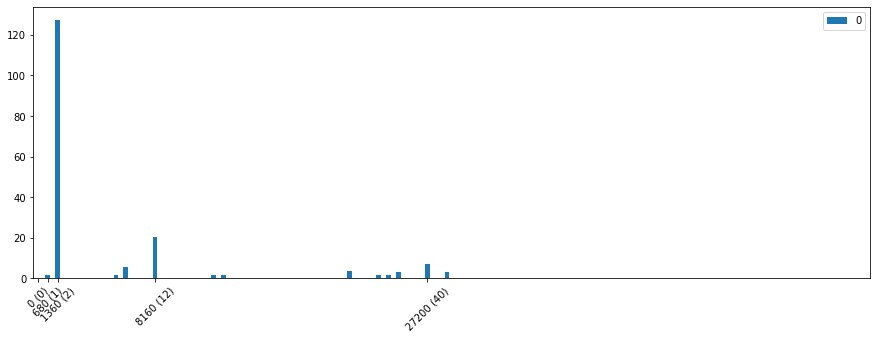

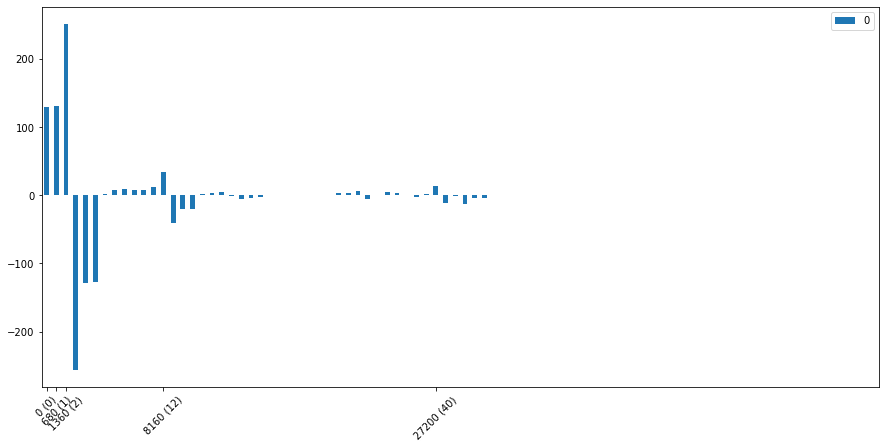

In [20]:
index = 0
extractor.show_occurrence_distribution(df_contracts.loc[index,'text'])

In [21]:
extractor.get_subject_context_starts(df_contracts.loc[index,'text'])

[1532]

In [22]:
for subj_context in df_contracts.loc[index, 'subj_context']:
    print(subj_context[:min(1000, len(subj_context))])
    print('====================')

PŘEDMĚT SMLOUVY
Zhotovitel se zavazuje k provedení stavebních prací v rámci projektu „Stezka pro cyklisty - k. ú. Starý Mateřov“ (dále jen
„veřejná zakázka“).

Objednatel se zavazuje předmět smlouvy převzít bez vad a nedodělků v době předání a zaplatit za ně zhotoviteli cenu podle
smlouvy a podmínek dohodnutých ve smlouvě.

Předmětem plnění je Stezka pro cyklisty — k. ú. Starý Mateřov v souladu s podmínkami provádění díla stanovenými projektovou

dokumentací. Dílo bude provedeno v rozsahu projektové dokumentace, zadávací dokumentace a položkového rozpočtu —
položkového výkazu výměr oceněného uchazečem.



In [25]:
text = df_contracts.loc[index, 'text']
print(text)

=======================2017126-115451.pdf=======================
SMLOUVA O DÍLO č. 1/2016

Smluvní strany
Objednatel (zadavatel): Obec Starý Mateřov .
ša Starý Mateřov 38, 530 02 Starý Mateřov
Identifikační číslo: 00274330
zastoupená: Pavlem Sehnoutkem, starostou obce
Zhotovitel: BW — Stavitelství, s.r.o.
se sídlem: Vysokomýtská 718, 534 01 Holice
Identifikační číslo: 15049752
DIČ: CZ15049752

zapsán v OR u KS v Hradci Králové oddíl C, vložka 332

Oprávněný zástupce:
- ve věcech smluvních: Ing. Pavel Pejcha, MBA
- ve věcech technických: David Vinopal
- ve věcech stavby: David Vinopal
Bankovní spojení: Československá obchodní banka, a. s.
Číslo účtu: 263835624/0300
X
ZÁKLADNÍ USTANOVENÍ

Smluvní strany se dohodly, že tento závazkový vztah a vztahy z něj vyplývající se řídí Občanským zákoníkem, a to podle ust. $
2586 a násl, tohoto zákoníku, v platném znění.

Smluvní strany prohlašují, že údaje uvedené ve smlouvě a taktéž oprávnění k podnikání jsou v souladu s právní skutečností v době
u

In [34]:
extractor.get_subject_context_start(text)

272726

In [35]:
extractor.get_subject_context_end(text, 272726)

275009

In [36]:
print(text[272726: 275009])

Vymezení předmětu veřejné zakázky 


2.1. Obecné vymezení předmětu veřejné zakázky 
Dle ustanovení § 26 a § 53 zákona se jedná o podlimitní veřejnou zakázku na stavební práce 


s názvem „Silnice III/26322 - Mlýny“ 


 


Klasifikace předmětu veřejné zakázky 


kód CPV: 45233141-9 - Práce na údržbě silnic  


kód CPV: 45233223-8 - Obnova povrchu vozovky 


kód CPV: 45233290-8 - Instalace a montáž dopravního značení 


kód CPV: 50230000-6 - Opravy a údržba silnic a dalších zařízení a související služby 


Předmět plnění této veřejné zakázky: 


Předmětem této veřejné zakázky je velkoplošná oprava silnice III/26322 mezi Českou 


Kamenicí a Kytlicí se začátkem na rozhraní Libereckého a Ústeckého kraje s koncem na 


začátku obce Kytlice – Mlýny. V celém úseku km 1,290 – km 3,645 budou provedeny 


údržbové práce v podobě souvislé údržby povrchu spočívající v pokládce asfaltových vrstev. 


Napojení na stávající komunikace v místech přiléhajících zpevněných ploch a křižovatek bude 



htt

In [682]:
df_contracts.at[index, 'subj_context2']

'  Článek II\n\nPředmět smlouvy\n(1)     Na základě této smlouvy se prodávající zavazuje dodat kupujícímu zboží a převést na něj vlastnické právo ke zboží, za podmínek dohodnutých v dalších ustanoveních smlouvy. Kupující se zavazuje zboží bez vad předané převzít a zaplatit za ně prodávajícímu kupní cenu, specifikovanou v čl. IV smlouvy, na základě dohodnutých platebních podmínek.\n(2)     Předmětem smlouvy je dodávka nových školících pomůcek a zařízení, v souladu s potřebami a požadavky kupujícího. Podrobná specifikace předmětu smlouvy je obsažena v Příloze č. 1 smlouvy. Prodávající se zavazuje dodat kupujícímu zboží ve smluveném množství, jakosti, provedení, termínech a ceně. Dále je prodávající povinen předat kupujícímu doklady, které se ke zboží vztahují a umožnit kupujícímu nabýt vlastnické právo ke zboží. Součástí předmětu smlouvy je též doprava předmětu smlouvy na místo plnění, jeho montáž, uvedení do provozu a zaškolení pracovníků kupujícího.\n(3) Prodávající se zavazuje umožnit

In [681]:
df_contracts.at[index, 'subj_context2'] = """  Článek II

Předmět smlouvy
(1)     Na základě této smlouvy se prodávající zavazuje dodat kupujícímu zboží a převést na něj vlastnické právo ke zboží, za podmínek dohodnutých v dalších ustanoveních smlouvy. Kupující se zavazuje zboží bez vad předané převzít a zaplatit za ně prodávajícímu kupní cenu, specifikovanou v čl. IV smlouvy, na základě dohodnutých platebních podmínek.
(2)     Předmětem smlouvy je dodávka nových školících pomůcek a zařízení, v souladu s potřebami a požadavky kupujícího. Podrobná specifikace předmětu smlouvy je obsažena v Příloze č. 1 smlouvy. Prodávající se zavazuje dodat kupujícímu zboží ve smluveném množství, jakosti, provedení, termínech a ceně. Dále je prodávající povinen předat kupujícímu doklady, které se ke zboží vztahují a umožnit kupujícímu nabýt vlastnické právo ke zboží. Součástí předmětu smlouvy je též doprava předmětu smlouvy na místo plnění, jeho montáž, uvedení do provozu a zaškolení pracovníků kupujícího.
(3) Prodávající se zavazuje umožnit osobám oprávněným k výkonu kontroly projektu, z něhož bude zakázka hrazena, provést kontrolu dokladů souvisejících s plněním zakázky a to minimálně do 31. 12. 2025.

(4) Prodávající se zavazuje uchovávat veškeré originály účetních dokladů a originály dalších dokumentů souvisejících s realizací projektu, z něhož bude zakázka hrazena, dle zákona č. 563/1991 Sb., o účetnictví, ve znění pozdějších předpisů, minimálně do 31. 12. 2025. 

(5) Prodávající se zavazuje řídit se v případě publicity na všech dokumentech souvisejících s projektem, z něhož bude zakázka hrazena, pravidly publicity projektů financovaných z programu OPVK a pravidly vizuální identity ESF v ČR dle příručky pro příjemce finanční podpory projektů OPVK.

(6) Prodávající se zavazuje dodržovat při plnění předmětu smlouvy opatření bezpečnosti, požární ochrany a ochrany zdraví při práci.

(7) Prodávající se zavazuje splnit předmět smlouvy prostřednictvím osob s potřebnou kvalifikací a odborností.

Článek III
"""

In [650]:
df_subj_context2 = df_contracts.loc[0:39]['subj_context2']
df_subj_context2

id
0     \nSmlouva nabývá platnosti a účinnosti dnem po...
1     \nTito uvedení zástupci jsou oprávněni jednat ...
2     \njménem zadavatele\n\n \n\n2. Předmět veřejné...
3     \n(dále jen „zhotovitel “ nebo „projektant“)\n...
4     \nvyhotovil tuto písemnou zprávu.\n\n1. Předmě...
5     \nprohlášení nebo v souvislosti s ní druhé sml...
6     \nmluvní straně vznikne.\nČlánek 2\nPředmět Sm...
7     \nOdůvodnění: Veřejnou zakázku malého rozsahu....
8     \nIdentifikace veřejné zakázky\n\nNázev veřejn...
9     \nvěstníku EU, na veřejnou zakázku „Programové...
10    \nJana Velíšková, tel. + 420 973 225 210.\n\n2...
11    \npovinen dodržet zásady podle $ 6 ZZVZ.\n\n2....
12    \ntéto Smlouvy a je odborně způsobilý ke splně...
13    \nrozhodl o výběru dodavatele k veřejné zakázc...
14    \nStrana 2\n\nII.\nPředmět plnění\n1. Předměte...
15    \nIdentifikace veřejné zakázky\n\n\tNázev veře...
16    \nOdůvodnění: Veřejnou zakázku malého rozsahu....
17    \nNabídku lze podat pouze elektronicky 